# Multi-Object Tracking (MOT) with YOLOv8 + ByteTrack

This notebook implements a full MOT pipeline for the MOT challenge using:
- **YOLOv8** for object detection
- **ByteTrack** for multi-object tracking
- **TrackEval** for performance evaluation (HOTA, CLEAR, IDF1)


## Install Dependencies
We install YOLOv8, ByteTrack, and supporting libraries for tracking and evaluation.


In [2]:
!pip install -q ultralytics git+https://github.com/ifzhang/ByteTrack.git onemetric loguru lap cython_bbox


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.8 MB/s eta 0:00:00


## Import Required Libraries
We import Python standard libraries, computer vision packages, and YOLOv8 for object detection.

In [3]:
# Set up imports and paths
import os
import shutil
import random
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from ultralytics import YOLO

# Input and output paths
INPUT_PATH = "/kaggle/input/surveillance-for-retail-stores/tracking"
TRAIN_PATH = os.path.join(INPUT_PATH, "train")
TEST_PATH = os.path.join(INPUT_PATH, "test")
OUTPUT_PATH = "/kaggle/working/dataset"
TRAIN_OUTPUT = os.path.join(OUTPUT_PATH, "images/train")
VAL_OUTPUT = os.path.join(OUTPUT_PATH, "images/val")
LABELS_TRAIN = os.path.join(OUTPUT_PATH, "labels/train")
LABELS_VAL = os.path.join(OUTPUT_PATH, "labels/val")

# Create necessary folders
for path in [TRAIN_OUTPUT, VAL_OUTPUT, LABELS_TRAIN, LABELS_VAL]:
    os.makedirs(path, exist_ok=True)
print("✅ Paths set up successfully!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Paths set up successfully!


## Dataset Preparation
We process MOT-format sequences into YOLOv8-compatible image and label directories.
- Convert bounding boxes to YOLO format.
- Split data into Train (80%) and Validation (20%).
- Generate `data.yaml` for YOLOv8 training.


In [4]:
# Complete dataset preparation function
def get_image_size(img_path):
    """Retrieve image dimensions using OpenCV."""
    img = cv2.imread(img_path)
    if img is not None:
        return img.shape[1], img.shape[0]  # (width, height)
    return None, None

def process_sequence(seq):
    """Process a single sequence and convert annotations to YOLO format."""
    print(f"Processing sequence {seq}...")
    
    seq_path = os.path.join(TRAIN_PATH, seq)
    gt_file = os.path.join(seq_path, "gt", "gt.txt")
    img_folder = os.path.join(seq_path, "img1")
    
    if not os.path.exists(gt_file) or not os.path.exists(img_folder):
        print(f"⚠️ Missing data for sequence {seq}, skipping...")
        return
    
    # Get sample image dimensions for normalization
    sample_img = os.path.join(img_folder, os.listdir(img_folder)[0])
    w_img, h_img = get_image_size(sample_img)
    if w_img is None or h_img is None:
        print(f"⚠️ Could not retrieve image size for sequence {seq}, skipping...")
        return
    
    # Read all annotations
    annotations = {}
    with open(gt_file, "r") as f:
        for line in f:
            values = line.strip().split(',')
            frame = int(float(values[0]))
            x, y, w, h = map(float, (values[2], values[3], values[4], values[5]))
            
            img_name = f"{frame:06d}.jpg"
            if img_name not in annotations:
                annotations[img_name] = []
                
            # Normalize to YOLO format
            x_center = (x + w / 2) / w_img
            y_center = (y + h / 2) / h_img
            w_norm = w / w_img
            h_norm = h / h_img
            
            annotations[img_name].append(f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")
    
    # Process train and validation splits
    seq_prefix = f"{seq}_"  # Add sequence prefix to avoid filename conflicts
    
    # Process train images
    for img_name in tqdm(os.listdir(img_folder), desc=f"Processing {seq} images"):
        if not img_name.endswith(".jpg"):
            continue
            
        src_img_path = os.path.join(img_folder, img_name)
        dest_img_name = seq_prefix + img_name
        
        # Determine if this image should be in train or val set
        is_train = random.random() < 0.8  # 80% train, 20% val
        
        if is_train:
            # Copy image to train folder
            dest_img_path = os.path.join(TRAIN_OUTPUT, dest_img_name)
            shutil.copy(src_img_path, dest_img_path)
            
            # Create label file if annotations exist
            if img_name in annotations:
                with open(os.path.join(LABELS_TRAIN, dest_img_name.replace(".jpg", ".txt")), "w") as f:
                    f.write("\n".join(annotations[img_name]))
        else:
            # Copy image to val folder
            dest_img_path = os.path.join(VAL_OUTPUT, dest_img_name)
            shutil.copy(src_img_path, dest_img_path)
            
            # Create label file if annotations exist
            if img_name in annotations:
                with open(os.path.join(LABELS_VAL, dest_img_name.replace(".jpg", ".txt")), "w") as f:
                    f.write("\n".join(annotations[img_name]))
    
    print(f"✅ Finished processing sequence {seq}")

def prepare_dataset():
    """Prepare the dataset by splitting and converting annotations."""
    # Set random seed for reproducibility
    random.seed(42)
    
    # Process all sequences
    sequences = ["02", "03", "05"]
    
    for seq in sequences:
        process_sequence(seq)
    
    # Print dataset statistics
    print("\n=== Dataset Statistics ===")
    print(f"Training images: {len(os.listdir(TRAIN_OUTPUT))}")
    print(f"Training labels: {len(os.listdir(LABELS_TRAIN))}")
    print(f"Validation images: {len(os.listdir(VAL_OUTPUT))}")
    print(f"Validation labels: {len(os.listdir(LABELS_VAL))}")
    
    # Check for mismatches
    train_imgs = set([f.replace(".jpg", "") for f in os.listdir(TRAIN_OUTPUT) if f.endswith(".jpg")])
    train_lbls = set([f.replace(".txt", "") for f in os.listdir(LABELS_TRAIN) if f.endswith(".txt")])
    val_imgs = set([f.replace(".jpg", "") for f in os.listdir(VAL_OUTPUT) if f.endswith(".jpg")])
    val_lbls = set([f.replace(".txt", "") for f in os.listdir(LABELS_VAL) if f.endswith(".txt")])
    
    train_missing = train_imgs - train_lbls
    val_missing = val_imgs - val_lbls
    
    if train_missing:
        print(f"Warning: {len(train_missing)} training images without labels")
    if val_missing:
        print(f"Warning: {len(val_missing)} validation images without labels")
    
    # Create data.yaml
    data_yaml = f"""
path: {OUTPUT_PATH}
train: images/train
val: images/val
nc: 1  # Number of classes
names: ['person']
"""
    with open(f"{OUTPUT_PATH}/data.yaml", "w") as f:
        f.write(data_yaml)
    print("✅ data.yaml created!")

# Run the improved dataset preparation
prepare_dataset()

Processing sequence 02...


Processing 02 images: 100%|██████████| 2782/2782 [00:34<00:00, 80.62it/s]


✅ Finished processing sequence 02
Processing sequence 03...


Processing 03 images: 100%|██████████| 2405/2405 [00:24<00:00, 99.36it/s] 


✅ Finished processing sequence 03
Processing sequence 05...


Processing 05 images: 100%|██████████| 3315/3315 [00:42<00:00, 77.87it/s]

✅ Finished processing sequence 05

=== Dataset Statistics ===
Training images: 6837
Training labels: 6837
Validation images: 1665
Validation labels: 1665
✅ data.yaml created!


## Model Evaluation on Test Data
We load the best YOLOv8 model and run inference on the test dataset.

In [5]:
# Cell 4: Evaluate on test data
# Load the best model
model = YOLO("/kaggle/input/epoch-50/other/default/1/best.pt")

# Test on the test dataset
test_results = model.predict(
    source=os.path.join(TEST_PATH, "01", "img1"),
    conf=0.25,  # Confidence threshold
    save=True,  # Save images with detections
    project="/kaggle/working/test_results"
)
print("✅ Testing completed!")


image 1/429 /kaggle/input/surveillance-for-retail-stores/tracking/test/01/img1/000001.jpg: 384x640 58 persons, 89.7ms
image 2/429 /kaggle/input/surveillance-for-retail-stores/tracking/test/01/img1/000002.jpg: 384x640 54 persons, 26.9ms
image 3/429 /kaggle/input/surveillance-for-retail-stores/tracking/test/01/img1/000003.jpg: 384x640 55 persons, 26.8ms
image 4/429 /kaggle/input/surveillance-for-retail-stores/tracking/test/01/img1/000004.jpg: 384x640 52 persons, 26.8ms
image 5/429 /kaggle/input/surveillance-for-retail-stores/tracking/test/01/img1/000005.jpg: 384x640 53 persons, 26.8ms
image 6/429 /kaggle/input/surveillance-for-retail-stores/tracking/test/01/img1/000006.jpg: 384x640 54 persons, 26.8ms
image 7/429 /kaggle/input/surveillance-for-retail-stores/tracking/test/01/img1/000007.jpg: 384x640 55 persons, 26.8ms
image 8/429 /kaggle/input/surveillance-for-retail-stores/tracking/test/01/img1/000008.jpg: 384x640 55 persons, 26.8ms
image 9/429 /kaggle/input/surveillance-for-retail-store

In [6]:
!git clone https://github.com/JonathonLuiten/TrackEval.git

Cloning into 'TrackEval'...
remote: Enumerating objects: 924, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 924 (delta 344), reused 319 (delta 319), pack-reused 546 (from 1)
Receiving objects: 100% (924/924), 393.80 KiB | 19.69 MiB/s, done.
Resolving deltas: 100% (619/619), done.


In [7]:
import sys
sys.path.append('/kaggle/working/TrackEval')

In [8]:
import trackeval
print("TrackEval successfully imported!")


TrackEval successfully imported!


## TrackEval Ground Truth Setup

TrackEval expects the MOTChallenge dataset to follow a specific folder structure for ground truth (GT) and sequence mapping.  
Here, we restructure the dataset so that evaluation metrics (HOTA, CLEAR, Identity) can be computed correctly.

Steps:
1. Create the required GT directories inside `TrackEval/data/gt/mot_challenge/`.
2. Copy the `seqinfo.ini` and `gt.txt` files for the sequences we want to evaluate.
3. Modify `seqinfo.ini` if necessary to match the expected sequence naming convention.
4. Create the `seqmaps` file listing the sequence IDs to evaluate.


In [9]:
# 1. Create GT folder for sequence 02 and copy necessary files
!mkdir -p /kaggle/working/TrackEval/data/gt/mot_challenge/02/gt/
!cp /kaggle/input/surveillance-for-retail-stores/tracking/train/02/seqinfo.ini \
    /kaggle/working/TrackEval/data/gt/mot_challenge/02/
!cp /kaggle/input/surveillance-for-retail-stores/tracking/train/02/gt/gt.txt \
    /kaggle/working/TrackEval/data/gt/mot_challenge/02/gt/

# 2. Fix sequence name in seqinfo.ini (TrackEval expects just '02', not 'MOT20-02')
!sed -i 's/name=MOT20-02/name=02/' /kaggle/working/TrackEval/data/gt/mot_challenge/02/seqinfo.ini

# 3. Create the seqmaps folder and file listing sequences for MOT17-train evaluation
!mkdir -p /kaggle/working/TrackEval/data/gt/mot_challenge/seqmaps
!echo "02" > /kaggle/working/TrackEval/data/gt/mot_challenge/seqmaps/MOT17-train.txt

# Verify files are in place
!ls -R /kaggle/working/TrackEval/data/gt/mot_challenge/


/kaggle/working/TrackEval/data/gt/mot_challenge/:
02  seqmaps

/kaggle/working/TrackEval/data/gt/mot_challenge/02:
gt  seqinfo.ini

/kaggle/working/TrackEval/data/gt/mot_challenge/02/gt:
gt.txt

/kaggle/working/TrackEval/data/gt/mot_challenge/seqmaps:
MOT17-train.txt


## Evaluate with HOTA

In [13]:
def evaluate_with_hota(self, sequence, predictions=None):
    """Evaluate tracking results using HOTA metrics"""
    from trackeval.datasets import MotChallenge2DBox
    from trackeval.metrics import HOTA, CLEAR, Identity
    from trackeval.evaluation import Evaluator
    import trackeval.plots as plots
    
    print(f"Evaluating sequence {sequence} with HOTA metrics...")
    
    # Output directory for results
    output_dir = Path(self.config['output']['save_dir'])
    mot_format_dir = output_dir / sequence / 'mot_format'
    
    # Create evaluation config
    eval_config = {
        'USE_PARALLEL': False,
        'NUM_PARALLEL_CORES': 1,
        'PRINT_RESULTS': True,
        'PRINT_ONLY_COMBINED': False,
        'PRINT_CONFIG': True,
        'TIME_PROGRESS': True,
        'OUTPUT_SUMMARY': True,
        'OUTPUT_DETAILED': True,
        'PLOT_CURVES': True,
    }
    
    # Create dataset config
    dataset_config = {
        'GT_FOLDER': str(Path(self.config['data']['base_path']) / 'train' / sequence / 'gt'),
        'TRACKERS_FOLDER': str(output_dir),
        'OUTPUT_FOLDER': str(output_dir / 'eval'),
        'TRACKERS_TO_EVAL': [sequence],
        'CLASSES_TO_EVAL': ['pedestrian'],
        'SPLIT_TO_EVAL': 'train',
        'INPUT_AS_ZIP': False,
        'PRINT_CONFIG': True,
        'DO_PREPROC': True,
        'TRACKER_SUB_FOLDER': 'mot_format',
        'OUTPUT_SUB_FOLDER': '',
        'TRACKER_DISPLAY_NAMES': {sequence: sequence}
    }
    
    # Create metrics config
    metrics_config = {'METRICS': ['HOTA', 'CLEAR', 'Identity']}
    
    # Create evaluation objects
    evaluator = Evaluator(eval_config)
    dataset = MotChallenge2DBox(dataset_config)
    metrics = [HOTA(metrics_config), CLEAR(metrics_config), Identity(metrics_config)]
    
    # Run evaluation
    results, messages = evaluator.evaluate(dataset, metrics)
    
    # Print summary
    print("\nHOTA Evaluation Summary:")
    for tracker in results:
        for seq in results[tracker]:
            print(f"Sequence: {seq}")
            print(f"HOTA: {results[tracker][seq]['HOTA']['HOTA']*100:.2f}%")
            print(f"DetA: {results[tracker][seq]['HOTA']['DetA']*100:.2f}%")
            print(f"AssA: {results[tracker][seq]['HOTA']['AssA']*100:.2f}%")
            print(f"MOTA: {results[tracker][seq]['CLEAR']['MOTA']*100:.2f}%")
            print(f"IDF1: {results[tracker][seq]['Identity']['IDF1']*100:.2f}%")
    
    # Add this after the evaluation
    if eval_config['PLOT_CURVES']:
        plot_dir = output_dir / 'eval' / 'plots'
        plot_dir.mkdir(exist_ok=True, parents=True)
        
        # Generate summary plots
        plots.plot_results(results, tracker_names=[sequence], class_name='pedestrian',
                          output_folder=str(plot_dir), plot_types=['hota_curve'])
        
        print(f"Saved plots to {plot_dir}")
    
    return results

## evaluate again

In [10]:
def evaluate_with_hota(self, sequence, predictions=None):
    """Evaluate tracking results using HOTA, CLEAR, and Identity metrics (TrackEval)"""

    import numpy as np
    np.int = np.int64  # Required for some TrackEval versions

    from trackeval.datasets import MotChallenge2DBox
    from trackeval.metrics import HOTA, CLEAR, Identity
    from trackeval.eval import Evaluator
    import trackeval.plotting as plots
    from pathlib import Path
    import os

    print(f"Evaluating sequence {sequence} with HOTA metrics...")

    # Output directory for results
    output_dir = Path(self.config['output']['save_dir'])
    mot_format_dir = output_dir / sequence / 'mot_format'

    # Evaluation config
    eval_config = {
        'USE_PARALLEL': False,
        'NUM_PARALLEL_CORES': 1,
        'PRINT_RESULTS': True,
        'PRINT_ONLY_COMBINED': False,
        'PRINT_CONFIG': True,
        'TIME_PROGRESS': True,
        'OUTPUT_SUMMARY': True,
        'OUTPUT_DETAILED': True,
        'PLOT_CURVES': True,
    }

    # Dataset config (hardcoded Kaggle/TrackEval paths kept)
    dataset_config = {
        'GT_FOLDER': '/kaggle/working/TrackEval/data/gt/mot_challenge/',
        'TRACKERS_FOLDER': '/kaggle/working/TrackEval/data/trackers/mot_challenge/BYTETrack/',
        'OUTPUT_FOLDER': '/kaggle/working/TrackEval/data/eval/',
        'TRACKERS_TO_EVAL': ['BYTETrack'],
        'CLASSES_TO_EVAL': ['pedestrian'],
        'SPLIT_TO_EVAL': 'train',
        'INPUT_AS_ZIP': False,
        'PRINT_CONFIG': True,
        'DO_PREPROC': True,
        'TRACKER_SUB_FOLDER': 'data',
        'OUTPUT_SUB_FOLDER': '',
        'TRACKER_DISPLAY_NAMES': {'BYTETrack': 'BYTETrack'},
        'SEQ_INFO': {  # Manual sequence length if needed
            '02': 2782
        }
    }

    # Metrics config
    metrics_config = {'METRICS': ['HOTA', 'CLEAR', 'Identity']}

    # Create evaluation objects
    evaluator = Evaluator(eval_config)
    dataset = MotChallenge2DBox(dataset_config)
    metrics = [HOTA(metrics_config), CLEAR(metrics_config), Identity(metrics_config)]

    # Run evaluation
    results, messages = evaluator.evaluate([dataset], metrics)

    # Print summary for each sequence/class
    print("\nHOTA Evaluation Summary:")
    for tracker in results['MotChallenge2DBox']:
        for seq in results['MotChallenge2DBox'][tracker]:
            for cls in results['MotChallenge2DBox'][tracker][seq]:
                metrics_dict = results['MotChallenge2DBox'][tracker][seq][cls]
                print(f"Sequence: {seq}, Class: {cls}")
                print(f"HOTA: {metrics_dict['HOTA']['HOTA'][0] * 100:.2f}%")
                print(f"DetA: {metrics_dict['HOTA']['DetA'][0] * 100:.2f}%")
                print(f"AssA: {metrics_dict['HOTA']['AssA'][0] * 100:.2f}%")
                print(f"MOTA: {metrics_dict['CLEAR']['MOTA'] * 100:.2f}%")
                print(f"IDF1: {metrics_dict['Identity']['IDF1'] * 100:.2f}%")

    # Save summary file and plots
    if eval_config['PLOT_CURVES']:
        plot_dir = output_dir / 'eval' / 'plots'
        plot_dir.mkdir(exist_ok=True, parents=True)

        summary_dir = output_dir / 'eval' / 'BYTETrack'
        summary_dir.mkdir(exist_ok=True, parents=True)

        cls = 'pedestrian'
        summary_file = summary_dir / f'{cls}_summary.txt'
        seq = list(results['MotChallenge2DBox']['BYTETrack'].keys())[0]
        metrics_dict = results['MotChallenge2DBox']['BYTETrack'][seq][cls]

        with open(summary_file, 'w') as f:
            metrics_list, values_list = [], []

            # Add HOTA metrics
            for key, value in metrics_dict['HOTA'].items():
                if isinstance(value, np.ndarray):
                    metrics_list.append(key)
                    values_list.append(value[0] * 100)

            # Add CLEAR metrics
            for key, value in metrics_dict['CLEAR'].items():
                metrics_list.append(key)
                values_list.append(value * 100)

            # Add Identity metrics
            for key, value in metrics_dict['Identity'].items():
                metrics_list.append(key)
                values_list.append(value * 100)

            f.write(' '.join(metrics_list) + '\n')
            f.write(' '.join([f"{val:.2f}" for val in values_list]) + '\n')

        print(f"Created summary file at {summary_file}")

        # Generate tracker comparison plot
        try:
            plots.plot_compare_trackers(
                tracker_folder=str(output_dir / 'eval'),
                tracker_list=['BYTETrack'],
                cls='pedestrian',
                output_folder=str(plot_dir)
            )
            print(f"Saved plots to {plot_dir}")
        except Exception as e:
            print(f"Error generating plots: {e}")

    return results


# Part 2 — Model Training, Tracking, and Evaluation
This section continues directly from Part 1, where we prepared the dataset and set up the environment.

**Objectives in Part 2:**
1. Use fine-tuned YOLOv8 for detection.
2. Use ByteTrack for multi-object tracking.
3. Evaluate tracking performance using standard MOT metrics (HOTA).
4. Visualize and analyze results.


In [14]:
# Import necessary libraries

import time
import gc
import json
import subprocess
import ast
from collections import defaultdict
from pathlib import Path
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# ByteTrack implementation
from yolox.tracker.byte_tracker import BYTETracker
from onemetric.cv.utils.iou import box_iou_batch

# Modified Configuration with improvements for better recall
CONFIG = {
    'detection': {
        'model': '/kaggle/input/epoch-50/other/default/1/best.pt',           # Larger model for accuracy
        'high_conf': 0.05,               # MODIFIED: Lowered from 0.35 to detect more people
        'low_conf': 0.005,                # MODIFIED: Lowered from 0.1 for ByteTrack
        'nms_threshold': 0.5,            # MODIFIED: Increased from 0.4 to allow more overlapping detections
        'batch_size': 8,                 # Batch size for detection
        'image_size': 1536,              # Input image size
        'augmentation': True,            # Use test-time augmentation
        'classes': [0],                  # MODIFIED: Explicitly specify person class
        'max_det': 500,                  # MODIFIED: Increased maximum detections per image
    },
    'tracking': {
        'track_thresh': 0.3,             # MODIFIED: Lowered from 0.5 to track lower confidence detections
        'track_buffer': 50,              # MODIFIED: Increased from 30 to maintain tracks longer
        'match_thresh': 0.6,             # MODIFIED: Lowered from 0.8 to make matching less strict
        'min_box_area': 10,              # Minimum detection area
        'frame_rate': 25,                # From dataset description
    },
    'data': {
        'base_path': '/kaggle/input/surveillance-for-retail-stores/tracking',
        'train_seqs': ['02', '03', '05'],
        'test_seq': '01',
        'cache_dir': '/kaggle/working/cache',
        'check_all_frames': True,       # MODIFIED: Added flag to process all frames
    },
    'output': {
        'save_dir': '/kaggle/working/results',
        'submission_file': '/kaggle/working/submission.csv',
        'visualization': True,          # Save visualization of tracking results
        'vis_limit': 20,                # Limit number of frames to visualize (to save space)
    },
    'validation': {
        'enabled': True,
        'val_sequence': '02',           # Use sequence 03 for validation
        'val_ratio': 0.2,               # Use 20% of frames for validation
    },
    'resources': {
        'num_workers': 4,
        'pin_memory': True,
        'max_memory_usage': 1,       # Use 85% of available GPU memory
    }
}

class DetectionCache:
    """Cache for storing detection results to avoid recomputing"""
    def __init__(self, cache_dir):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True, parents=True)
        self.cache = {}
        self.hits = 0
        self.misses = 0
    
    def get(self, sequence, frame_id):
        """Get cached detection if available"""
        cache_key = f"{sequence}_{frame_id}"
        if cache_key in self.cache:
            self.hits += 1
            return self.cache[cache_key]
        
        cache_file = self.cache_dir / f"{cache_key}.npy"
        if cache_file.exists():
            try:
                detection = np.load(cache_file, allow_pickle=True)
                self.cache[cache_key] = detection
                self.hits += 1
                return detection
            except Exception as e:
                print(f"Error loading cache: {e}")
                self.misses += 1
                return None
        
        self.misses += 1
        return None
    
    def put(self, sequence, frame_id, detection):
        """Cache detection result"""
        cache_key = f"{sequence}_{frame_id}"
        self.cache[cache_key] = detection
        
        # Save to disk
        cache_file = self.cache_dir / f"{cache_key}.npy"
        np.save(cache_file, detection)
        
        # Keep cache size reasonable
        if len(self.cache) > 1000:
            # Remove random 200 items
            keys_to_remove = list(self.cache.keys())[:200]
            for key in keys_to_remove:
                del self.cache[key]
    
    def stats(self):
        """Return cache statistics"""
        total = self.hits + self.misses
        hit_rate = self.hits / total if total > 0 else 0
        return {
            'hits': self.hits,
            'misses': self.misses,
            'hit_rate': hit_rate,
            'size': len(self.cache)
        }

class TrackingDataset:
    """Dataset for loading image sequences"""
    def __init__(self, base_path, sequence, frame_range=None):
        self.base_path = Path(base_path)
        self.sequence = sequence
        self.img_dir = self.base_path / ('train' if sequence in CONFIG['data']['train_seqs'] else 'test') / sequence / 'img1'
        self.frame_files = sorted([f for f in self.img_dir.glob('*.jpg')])
        
        # Apply frame range if specified
        if frame_range is not None:
            start, end = frame_range
            self.frame_files = self.frame_files[start:end]
        
        print(f"Loaded {len(self.frame_files)} frames from sequence {sequence}")
    
    def __len__(self):
        return len(self.frame_files)
    
    def __getitem__(self, idx):
        img_path = self.frame_files[idx]
        frame_id = int(img_path.stem)
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return {
            'frame_id': frame_id,
            'image': img,
            'path': str(img_path)
        }
    
    def get_batch(self, start_idx, batch_size):
        """Get a batch of frames"""
        end_idx = min(start_idx + batch_size, len(self))
        batch = []
        frame_ids = []
        
        for i in range(start_idx, end_idx):
            data = self[i]
            batch.append(data['image'])
            frame_ids.append(data['frame_id'])
            
        return batch, frame_ids

def format_track_for_submission(track, frame_id):
    """Format track for submission"""
    return {
        'tracked_id': float(track.track_id),
        'x': float(track.tlwh[0]),
        'y': float(track.tlwh[1]),
        'w': float(track.tlwh[2]),
        'h': float(track.tlwh[3]),
        'confidence': float(track.score)
    }

def load_ground_truth(base_path, sequence):
    """Load ground truth data for validation"""
    gt_path = Path(base_path) / 'train' / sequence / 'gt' / 'gt.txt'
    if not gt_path.exists():
        print(f"Ground truth file not found: {gt_path}")
        return {}
    
    gt_data = {}
    with open(gt_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            frame_id = int(parts[0])
            track_id = int(parts[1])
            x, y, w, h = float(parts[2]), float(parts[3]), float(parts[4]), float(parts[5])
            confidence = float(parts[6])
            class_id = int(parts[7])
            visibility = float(parts[8])
            
            if frame_id not in gt_data:
                gt_data[frame_id] = []
                
            gt_data[frame_id].append({
                'track_id': track_id,
                'bbox': [x, y, w, h],
                'confidence': confidence,
                'class_id': class_id,
                'visibility': visibility
            })
    
    return gt_data

def compute_iou(box1, box2):
    """Compute IOU between boxes in [x, y, w, h] format"""
    # Convert to [x1, y1, x2, y2]
    b1_x1, b1_y1 = box1[0], box1[1]
    b1_x2, b1_y2 = box1[0] + box1[2], box1[1] + box1[3]
    
    b2_x1, b2_y1 = box2[0], box2[1]
    b2_x2, b2_y2 = box2[0] + box2[2], box2[1] + box2[3]
    
    # Intersection area
    inter_x1 = max(b1_x1, b2_x1)
    inter_y1 = max(b1_y1, b2_y1)
    inter_x2 = min(b1_x2, b2_x2)
    inter_y2 = min(b1_y2, b2_y2)
    
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    
    # Union area
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    
    union_area = b1_area + b2_area - inter_area
    
    # IOU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def evaluate_tracking(predictions, ground_truth, iou_threshold=0.5):
    """Simple evaluation of tracking performance"""
    total_gt = 0
    total_pred = 0
    total_matches = 0
    id_switches = 0
    last_matches = {}  # frame_id -> {gt_id: pred_id}
    
    for frame_id in sorted(ground_truth.keys()):
        if frame_id not in predictions:
            continue
            
        gt_tracks = ground_truth[frame_id]
        pred_tracks = predictions[frame_id]
        
        total_gt += len(gt_tracks)
        total_pred += len(pred_tracks)
        
        # Create cost matrix based on IOU
        cost_matrix = np.zeros((len(gt_tracks), len(pred_tracks)))
        for i, gt in enumerate(gt_tracks):
            for j, pred in enumerate(pred_tracks):
                cost_matrix[i, j] = compute_iou(gt['bbox'], 
                                               [pred['x'], pred['y'], pred['w'], pred['h']])
        
        # Assign using greedy matching
        matches = []
        matched_gt = set()
        matched_pred = set()
        
        # Sort all matches by IOU (descending)
        match_indices = np.where(cost_matrix >= iou_threshold)
        matched_costs = [(i, j, cost_matrix[i, j]) for i, j in zip(*match_indices)]
        matched_costs.sort(key=lambda x: x[2], reverse=True)
        
        # Assign matches greedily
        for i, j, cost in matched_costs:
            if i not in matched_gt and j not in matched_pred:
                matches.append((i, j))
                matched_gt.add(i)
                matched_pred.add(j)
        
        total_matches += len(matches)
        
        # Count ID switches
        current_matches = {}
        for i, j in matches:
            gt_id = gt_tracks[i]['track_id']
            pred_id = pred_tracks[j]['tracked_id']
            current_matches[gt_id] = pred_id
            
            # Check for ID switch
            if frame_id > 1 and gt_id in last_matches:
                if last_matches[gt_id] != pred_id:
                    id_switches += 1
        
        last_matches = current_matches
    
    # Calculate metrics
    precision = total_matches / total_pred if total_pred > 0 else 0
    recall = total_matches / total_gt if total_gt > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'id_switches': id_switches,
        'total_gt': total_gt,
        'total_pred': total_pred,
        'total_matches': total_matches
    }

def visualize_tracking(image, tracks, frame_id, output_dir):
    """Visualize tracking results"""
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)
    
    img = image.copy()
    
    # Generate random colors for each track ID
    np.random.seed(42)
    color_map = {}
    
    for track in tracks:
        track_id = int(track['tracked_id'])
        if track_id not in color_map:
            color_map[track_id] = tuple(map(int, np.random.randint(0, 255, 3)))
            
        x, y, w, h = int(track['x']), int(track['y']), int(track['w']), int(track['h'])
        color = color_map[track_id]
        confidence = track['confidence']
        
        # Draw bounding box
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        
        # Draw label
        label = f"ID:{track_id} {confidence:.2f}"
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Add frame number
    cv2.putText(img, f"Frame: {frame_id}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Save image
    output_path = output_dir / f"frame_{frame_id:06d}.jpg"
    cv2.imwrite(str(output_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    return img

def detection_to_tlbr(detection):
    """Convert detection to top-left bottom-right format"""
    x, y, w, h = detection[:4]
    return np.array([x, y, x + w, y + h])

class MOTTracker:
    """Multi-Object Tracking system using YOLOv8 and ByteTrack"""
    
    def __init__(self, config):
        self.config = config
        self.detector = None
        self.tracker = None
        self.cache = DetectionCache(config['data']['cache_dir'])
        
        # Initialize output directory
        self.output_dir = Path(config['output']['save_dir'])
        self.output_dir.mkdir(exist_ok=True, parents=True)
        
        # For storing results
        self.tracking_results = {}
        
    def _init_detector(self):
        """Initialize YOLOv8 detector"""
        print("Initializing YOLOv8 detector...")
        model_path = self.config['detection']['model']
        
        try:
            model = YOLO(model_path)
            model.fuse()  # Fuse model layers for better performance
            return model
        except Exception as e:
            print(f"Error initializing detector: {e}")
            # Fallback to smaller model if necessary
            print("Falling back to yolov8n.pt")
            return YOLO('yolov8n.pt')
    
    def _init_tracker(self):
        """Initialize ByteTrack tracker"""
        print("Initializing ByteTrack tracker...")
        
        # Create an args object with the required configuration
        class Args:
            pass
        
        args = Args()
        
        # Set tracker parameters on the args object
        args.track_thresh = self.config['tracking']['track_thresh']
        args.track_buffer = self.config['tracking']['track_buffer']
        args.match_thresh = self.config['tracking']['match_thresh']
        args.min_box_area = self.config['tracking']['min_box_area']

        args.mot20 = True
        
        # Monkey patch numpy to avoid the np.float deprecation error
        import numpy as np
        if not hasattr(np, 'float'):
            np.float = float  # Add the missing attribute temporarily
        
        # Initialize tracker with proper args
        return BYTETracker(
            args=args,
            frame_rate=self.config['tracking']['frame_rate']
        )
    
    def _detect_batch(self, images):
        """Run detection on a batch of images"""
        if self.detector is None:
            self.detector = self._init_detector()
            
        results = self.detector(
            images, 
            conf=self.config['detection']['low_conf'],
            iou=self.config['detection']['nms_threshold'],
            augment=self.config['detection']['augmentation'],
            classes=self.config['detection']['classes'],
            max_det=self.config['detection']['max_det'],
            verbose=False
        )
        
        return results
    
    def _filter_detections(self, detections):
        """Filter detections for ByteTrack format
           MODIFIED: Simplified to keep more detections
        """
        filtered = []
        
        for det in detections:
            xyxy = det.boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2 format
            conf = det.boxes.conf.cpu().numpy()
            
            # Convert to [x, y, w, h, conf] format for ByteTrack
            if len(xyxy) > 0:
                result = np.zeros((len(xyxy), 5))
                result[:, 0] = xyxy[:, 0]  # x1
                result[:, 1] = xyxy[:, 1]  # y1
                result[:, 2] = xyxy[:, 2]  # x2
                result[:, 3] = xyxy[:, 3]  # y2
                result[:, 4] = conf       # conf
                filtered.append(result)
            else:
                filtered.append(np.zeros((0, 5)))
                
        return filtered
    
    def _update_tracker(self, detections, frame_id, img_info):
        """Update tracker with new detections"""
        if self.tracker is None:
            self.tracker = self._init_tracker()
            
        # ByteTrack expects [x1, y1, x2, y2, score] format
        tracks = self.tracker.update(
            detections,
            [img_info['height'], img_info['width']],
            (img_info['height'], img_info['width'])
        )
        
        return tracks
    
    
    # MODIFIED: Added pre-processing for improved detection
    ''''''
    
    def _preprocess_image(self, image):
        img_float = image.astype(np.float32) / 255.0
        img_gamma = np.power(img_float, 1/1.2)  # Gamma correction
        img_processed = (img_gamma * 255).astype(np.uint8)
# Apply histogram equalization
        img_yuv = cv2.cvtColor(img_processed, cv2.COLOR_RGB2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        img_processed = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return img_processed
    def process_sequence(self, sequence, validation=False):
        """Process a complete video sequence and save results in MOTChallenge format"""
        print(f"Processing sequence: {sequence}")
        
        # Determine if this is training or test data
        is_train = sequence in self.config['data']['train_seqs']
        data_type = 'train' if is_train else 'test'
        
        # For validation, split sequence
        frame_range = None
        if validation and is_train and sequence == self.config['validation']['val_sequence']:
            # Get validation split
            dataset = TrackingDataset(self.config['data']['base_path'], sequence)
            total_frames = len(dataset)
            val_start = int(total_frames * (1 - self.config['validation']['val_ratio']))
            frame_range = (val_start, total_frames)
            print(f"Using frames {val_start}-{total_frames} for validation")
        
        # Load dataset
        dataset = TrackingDataset(self.config['data']['base_path'], sequence, frame_range)
        
        # Initialize tracking results
        tracking_results = {}
    
        # MOT output directory
        mot_format_dir = self.output_dir / sequence / 'mot_format'
        mot_format_dir.mkdir(exist_ok=True, parents=True)
        results_file = mot_format_dir / f"{sequence}.txt"
    
        # Process frames in batches
        batch_size = self.config['detection']['batch_size']
        
        for start_idx in tqdm(range(0, len(dataset), batch_size), desc=f"Processing {sequence}"):
            try:
                # Get batch of frames
                images, frame_ids = dataset.get_batch(start_idx, batch_size)
                
                # Preprocess images
                processed_images = [self._preprocess_image(img) for img in images]
                
                # Check if all frames are already cached
                all_cached = True
                cached_detections = []
                
                for idx, frame_id in enumerate(frame_ids):
                    cached = self.cache.get(sequence, frame_id)
                    if cached is None:
                        all_cached = False
                        break
                    cached_detections.append(cached)
                
                # Run detection if not all frames are cached
                if not all_cached:
                    batch_results = self._detect_batch(processed_images)
                    batch_detections = self._filter_detections(batch_results)
                    
                    # Cache detections
                    for idx, (frame_id, detections) in enumerate(zip(frame_ids, batch_detections)):
                        self.cache.put(sequence, frame_id, detections)
                        cached_detections.append(detections)
                
                # Process each frame with the tracker
                with open(results_file, 'a') as f:
                    for idx, (image, frame_id) in enumerate(zip(images, frame_ids)):
                        detections = cached_detections[idx]
                        
                        # Get image info
                        height, width = image.shape[:2]
                        img_info = {'height': height, 'width': width}
                        
                        # Update tracker
                        online_tracks = self._update_tracker(detections, frame_id, img_info)
                        
                        # Format tracks for output
                        formatted_tracks = []
                        for track in online_tracks:
                            formatted_track = format_track_for_submission(track, frame_id)
                            formatted_tracks.append(formatted_track)
                        
                        # Apply high confidence threshold
                        high_conf_tracks = [
                            track for track in formatted_tracks 
                            if track['confidence'] >= self.config['detection']['high_conf']
                        ]
                        
                        # Store results
                        tracking_results[frame_id] = high_conf_tracks
    
                        # Save in MOTChallenge format
                        for track in high_conf_tracks:
                            track_id = track['tracked_id']
                            x, y, w, h = track['x'], track['y'], track['w'], track['h']
                            score = track['confidence']
    
                            # MOT format: frame_id, track_id, x, y, w, h, score, class, visibility
                            f.write(f"{frame_id},{track_id},{x},{y},{w},{h},{score},1,1\n")
    
                        # Visualize if enabled (limit to save space)
                        if self.config['output']['visualization'] and len(high_conf_tracks) > 0:
                            if (start_idx // batch_size) < self.config['output']['vis_limit']:
                                vis_dir = self.output_dir / sequence / 'visualization'
                                visualize_tracking(image, high_conf_tracks, frame_id, vis_dir)
                
                # Free memory
                if start_idx % (batch_size * 10) == 0:
                    torch.cuda.empty_cache()
                    gc.collect()
            
            except Exception as e:
                print(f"Error processing batch at {start_idx}: {e}")
                continue
                
        # Store results for this sequence
        self.tracking_results[sequence] = tracking_results
    
        # Log cache stats
        print(f"Cache stats: {self.cache.stats()}")
        print(f"Saved MOTChallenge results to {results_file}")
    
        return tracking_results
    '''
         
    '''
    def validate(self, sequence, predictions=None):
        """Validate tracking results against ground truth"""
        if predictions is None and sequence in self.tracking_results:
            predictions = self.tracking_results[sequence]
        elif predictions is None:
            print(f"No predictions found for sequence {sequence}")
            return None
            
        # Load ground truth
        ground_truth = load_ground_truth(self.config['data']['base_path'], sequence)
        
        if not ground_truth:
            print(f"No ground truth found for sequence {sequence}")
            return None
            
        # Format predictions for evaluation
        formatted_predictions = {}
        for frame_id, tracks in predictions.items():
            formatted_predictions[frame_id] = tracks
            
        # Evaluate
        metrics = evaluate_tracking(formatted_predictions, ground_truth)
        
        print(f"Validation results for {sequence}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
            
        return metrics
    
    # MODIFIED: Added function to optimize thresholds
    def optimize_thresholds(self, sequence, validation=True):
        """Find optimal detection and tracking thresholds"""
        print("Optimizing thresholds for better recall...")
        
        # Define threshold ranges to test
        #detection_thresholds = [0.05,0.1, 0.15, 0.2, 0.25]
        #nms_thresholds = [0.4, 0.45, 0.5, 0.55,0.6]
        detection_thresholds = [0.05, 0.1, 0.15, 0.2]  
        nms_thresholds = [0.5, 0.55, 0.6, 0.65]  
        
        best_f1 = 0
        best_config = None
        
        # Load dataset and ground truth
        dataset = TrackingDataset(self.config['data']['base_path'], sequence)
        ground_truth = load_ground_truth(self.config['data']['base_path'], sequence)
        
        # Use a subset of frames for optimization
        sample_frames = min(20, len(dataset))
        sample_indices = np.linspace(0, len(dataset)-1, sample_frames, dtype=int)
        
        for det_thresh in detection_thresholds:
            for nms_thresh in nms_thresholds:
                # Update configuration
                temp_config = self.config.copy()
                temp_config['detection']['high_conf'] = det_thresh
                temp_config['detection']['nms_threshold'] = nms_thresh
                
                # Initialize temporary tracker
                temp_tracker = MOTTracker(temp_config)
                
                # Process sample frames
                sample_results = {}
                for idx in tqdm(sample_indices, desc=f"Testing thresh: {det_thresh}/{nms_thresh}"):
                    data = dataset[idx]
                    frame_id = data['frame_id']
                    image = data['image']
                    
                    # Preprocess image
                    processed_image = temp_tracker._preprocess_image(image)
                    
                    # Run detection
                    if temp_tracker.detector is None:
                        temp_tracker.detector = temp_tracker._init_detector()
                    
                    results = temp_tracker.detector(
                        processed_image, 
                        conf=temp_config['detection']['low_conf'],
                        iou=temp_config['detection']['nms_threshold'],
                        classes=temp_config['detection']['classes'],
                        verbose=False
                    )
                    
                    # Filter detections
                    detections = temp_tracker._filter_detections([results])[0]
                    
                    # Get image info
                    height, width = image.shape[:2]
                    img_info = {'height': height, 'width': width}
                    
                    # Update tracker
                    if temp_tracker.tracker is None:
                        temp_tracker.tracker = temp_tracker._init_tracker()
                    
                    online_tracks = temp_tracker._update_tracker(detections, frame_id, img_info)
                    
                    # Format tracks for output
                    formatted_tracks = []
                    for track in online_tracks:
                        # Convert from tlwh to submission format
                        formatted_track = format_track_for_submission(track, frame_id)
                        # Apply high confidence threshold
                        if formatted_track['confidence'] >= temp_config['detection']['high_conf']:
                            formatted_tracks.append(formatted_track)
                    
                    # Store results
                    sample_results[frame_id] = formatted_tracks
                
                # Evaluate on sample frames
                sample_gt = {k: v for k, v in ground_truth.items() if k in sample_results}
                metrics = evaluate_tracking(sample_results, sample_gt)
                
                print(f"Det: {det_thresh}, NMS: {nms_thresh} - F1: {metrics['f1']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")
                
                # Update best config if better F1
                if metrics['f1'] > best_f1:
                    best_f1 = metrics['f1']
                    best_config = {
                        'detection_thresh': det_thresh,
                        'nms_thresh': nms_thresh,
                        'metrics': metrics
                    }
        
        if best_config:
            print(f"Best configuration: Detection thresh={best_config['detection_thresh']}, NMS thresh={best_config['nms_thresh']}")
            print(f"Best metrics: F1={best_config['metrics']['f1']:.4f}, Precision={best_config['metrics']['precision']:.4f}, Recall={best_config['metrics']['recall']:.4f}")
            
            # Update config with best values
            self.config['detection']['high_conf'] = best_config['detection_thresh']
            self.config['detection']['nms_threshold'] = best_config['nms_thresh']
            
            # Reset detector and tracker to use new values
            self.detector = None
            self.tracker = None
        
        return best_config
    
    
    def generate_submission(self, output_path=None):
        """Generate submission file for competition"""
        if output_path is None:
            output_path = self.config['output']['submission_file']
                
        # Try to load submission template
        template_path = '/kaggle/input/surveillance-for-retail-stores/tracking/submission_file.csv'
        if os.path.exists(template_path):
            submission_template = pd.read_csv(template_path)
        else:
            print("Submission template not found, creating new one")
            # Create from scratch based on test sequence data
            sequence = self.config['data']['test_seq']
            if sequence not in self.tracking_results:
                print("Error: No tracking results found for test sequence")
                return None
                
            # Get all frame IDs
            frame_ids = sorted(self.tracking_results[sequence].keys())
            
            # Create template rows
            template_rows = []
            for frame_id in frame_ids:
                template_rows.append({
                    'objective': 'tracking',
                    'frame': int(frame_id),
                    'objects': '[]'  # Will be populated later
                })
                
            submission_template = pd.DataFrame(template_rows)
        
        # Process each row in the template
        updated_rows = []
        
        for _, row in tqdm(submission_template.iterrows(), total=len(submission_template), desc="Generating submission"):
            if row['objective'] == 'tracking':
                # This is a tracking row
                frame_id = int(row['frame'])
                frame_results = []
                
                # Get tracking results for test sequence
                sequence = self.config['data']['test_seq']
                if sequence in self.tracking_results and frame_id in self.tracking_results[sequence]:
                    frame_results = self.tracking_results[sequence][frame_id]
                
                # Update row
                row['objects'] = json.dumps(frame_results if frame_results else [])
                
            updated_rows.append(row)
            
        # Create updated DataFrame
        submission_df = pd.DataFrame(updated_rows)
        
        # Save submission
        submission_df.to_csv(output_path, index=False)
        print(f"Submission saved to {output_path}")
        
        return submission_df

    def evaluate_with_hota(self, sequence, predictions=None):
        """Evaluate tracking results using HOTA, CLEAR, and Identity metrics (TrackEval)"""
    
        import numpy as np
        np.int = np.int64  # Required for some TrackEval versions
    
        from trackeval.datasets import MotChallenge2DBox
        from trackeval.metrics import HOTA, CLEAR, Identity
        from trackeval.eval import Evaluator
        import trackeval.plotting as plots
        from pathlib import Path
        import os
    
        print(f"Evaluating sequence {sequence} with HOTA metrics...")
    
        # Output directory for results
        output_dir = Path(self.config['output']['save_dir'])
        mot_format_dir = output_dir / sequence / 'mot_format'
    
        # Evaluation config
        eval_config = {
            'USE_PARALLEL': False,
            'NUM_PARALLEL_CORES': 1,
            'PRINT_RESULTS': True,
            'PRINT_ONLY_COMBINED': False,
            'PRINT_CONFIG': True,
            'TIME_PROGRESS': True,
            'OUTPUT_SUMMARY': True,
            'OUTPUT_DETAILED': True,
            'PLOT_CURVES': True,
        }

        # Dataset config (hardcoded Kaggle/TrackEval paths kept)
        dataset_config = {
            'GT_FOLDER': '/kaggle/working/TrackEval/data/gt/mot_challenge/',
            'TRACKERS_FOLDER': '/kaggle/working/TrackEval/data/trackers/mot_challenge/BYTETrack/',
            'OUTPUT_FOLDER': '/kaggle/working/TrackEval/data/eval/',
            'TRACKERS_TO_EVAL': ['BYTETrack'],
            'CLASSES_TO_EVAL': ['pedestrian'],
            'SPLIT_TO_EVAL': 'train',
            'INPUT_AS_ZIP': False,
            'PRINT_CONFIG': True,
            'DO_PREPROC': True,
            'TRACKER_SUB_FOLDER': 'data',
            'OUTPUT_SUB_FOLDER': '',
            'TRACKER_DISPLAY_NAMES': {'BYTETrack': 'BYTETrack'},
            'SEQ_INFO': {  # Manual sequence length if needed
                '02': 2782
            }
        }
    
        # Metrics config
        metrics_config = {'METRICS': ['HOTA', 'CLEAR', 'Identity']}
    
        # Create evaluation objects
        evaluator = Evaluator(eval_config)
        dataset = MotChallenge2DBox(dataset_config)
        metrics = [HOTA(metrics_config), CLEAR(metrics_config), Identity(metrics_config)]
    
        # Run evaluation
        results, messages = evaluator.evaluate([dataset], metrics)
    
        # Print summary for each sequence/class
        print("\nHOTA Evaluation Summary:")
        for tracker in results['MotChallenge2DBox']:
            for seq in results['MotChallenge2DBox'][tracker]:
                for cls in results['MotChallenge2DBox'][tracker][seq]:
                    metrics_dict = results['MotChallenge2DBox'][tracker][seq][cls]
                    print(f"Sequence: {seq}, Class: {cls}")
                    print(f"HOTA: {metrics_dict['HOTA']['HOTA'][0] * 100:.2f}%")
                    print(f"DetA: {metrics_dict['HOTA']['DetA'][0] * 100:.2f}%")
                    print(f"AssA: {metrics_dict['HOTA']['AssA'][0] * 100:.2f}%")
                    print(f"MOTA: {metrics_dict['CLEAR']['MOTA'] * 100:.2f}%")
                    print(f"IDF1: {metrics_dict['Identity']['IDF1'] * 100:.2f}%")
    
        # Save summary file and plots
        if eval_config['PLOT_CURVES']:
            plot_dir = output_dir / 'eval' / 'plots'
            plot_dir.mkdir(exist_ok=True, parents=True)
    
            summary_dir = output_dir / 'eval' / 'BYTETrack'
            summary_dir.mkdir(exist_ok=True, parents=True)
    
            cls = 'pedestrian'
            summary_file = summary_dir / f'{cls}_summary.txt'
            seq = list(results['MotChallenge2DBox']['BYTETrack'].keys())[0]
            metrics_dict = results['MotChallenge2DBox']['BYTETrack'][seq][cls]
    
            with open(summary_file, 'w') as f:
                metrics_list, values_list = [], []
    
                # Add HOTA metrics
                for key, value in metrics_dict['HOTA'].items():
                    if isinstance(value, np.ndarray):
                        metrics_list.append(key)
                        values_list.append(value[0] * 100)
    
                # Add CLEAR metrics
                for key, value in metrics_dict['CLEAR'].items():
                    metrics_list.append(key)
                    values_list.append(value * 100)
    
                # Add Identity metrics
                for key, value in metrics_dict['Identity'].items():
                    metrics_list.append(key)
                    values_list.append(value * 100)
    
                f.write(' '.join(metrics_list) + '\n')
                f.write(' '.join([f"{val:.2f}" for val in values_list]) + '\n')

            print(f"Created summary file at {summary_file}")
    
            # Generate tracker comparison plot
            try:
                plots.plot_compare_trackers(
                    tracker_folder=str(output_dir / 'eval'),
                    tracker_list=['BYTETrack'],
                    cls='pedestrian',
                    output_folder=str(plot_dir)
                )
                print(f"Saved plots to {plot_dir}")
            except Exception as e:
                print(f"Error generating plots: {e}")
    
        return results


In [15]:
if __name__ == "__main__":
    # Run the tracking pipeline
    #submission, hota_results = run_tracking_pipeline()
    """Run the complete tracking pipeline with HOTA evaluation"""
    # Start timer
    start_time = time.time()     
    
    # Create tracker
    tracker = MOTTracker(CONFIG)    
    
    # Process validation sequence
    if CONFIG['validation']['enabled']:
        val_sequence = CONFIG['validation']['val_sequence']
        print(f"Processing validation sequence: {val_sequence}")
        tracker.process_sequence(val_sequence, validation=True)
        
        # Evaluate with traditional metrics
        tracker.validate(val_sequence)

Processing validation sequence: 02
Processing sequence: 02
Loaded 2782 frames from sequence 02
Using frames 2225-2782 for validation
Loaded 557 frames from sequence 02


Processing 02:   0%|          | 0/70 [00:00<?, ?it/s]

Initializing YOLOv8 detector...
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs
Initializing ByteTrack tracker...


Processing 02: 100%|██████████| 70/70 [01:03<00:00,  1.10it/s]


Cache stats: {'hits': 0, 'misses': 70, 'hit_rate': 0.0, 'size': 557}
Saved MOTChallenge results to /kaggle/working/results/02/mot_format/02.txt
Validation results for 02:
  precision: 0.9433
  recall: 0.9062
  f1: 0.9244
  id_switches: 162.0000
  total_gt: 37492.0000
  total_pred: 36018.0000
  total_matches: 33975.0000


## Prepare Tracker Output for TrackEval

After running the tracking pipeline, we need to place the tracker outputs (`.txt` files in MOTChallenge format) into the directory structure expected by TrackEval:

- `TrackEval/data/trackers/mot_challenge/<tracker_name>/<split>/<tracker_name>/data/`
- In our case: `BYTETrack` as the tracker name and `MOT17-train` as the split.

This step copies the results from the tracking pipeline into the correct location so that TrackEval can read and evaluate them.


## Prepare Tracker Outputs for TrackEval

We organize the tracker outputs into the format required by TrackEval:
1. Copy tracker results to the generic `BYTETrack/data/` folder.
2. Move results into the specific `MOT17-train` folder structure for evaluation.


In [33]:
!mkdir -p TrackEval/data/trackers/mot_challenge/BYTETrack/data/
!cp /kaggle/working/results/*/mot_format/* TrackEval/data/trackers/mot_challenge/BYTETrack/data/

!mkdir -p /kaggle/working/TrackEval/data/trackers/mot_challenge/BYTETrack/MOT17-train/BYTETrack/data/
!cp /kaggle/working/TrackEval/data/trackers/mot_challenge/BYTETrack/data/02.txt \
      /kaggle/working/TrackEval/data/trackers/mot_challenge/BYTETrack/MOT17-train/BYTETrack/data/


## Prepare Ground Truth for TrackEval

We move the MOT ground truth data into the `MOT17-train` folder structure, so TrackEval can match GT with tracker predictions.


In [34]:
!mkdir -p /kaggle/working/TrackEval/data/gt/mot_challenge/MOT17-train/02/gt
!mv /kaggle/working/TrackEval/data/gt/mot_challenge/02/gt/gt.txt \
      /kaggle/working/TrackEval/data/gt/mot_challenge/MOT17-train/02/gt/


mv: cannot stat '/kaggle/working/TrackEval/data/gt/mot_challenge/02/gt/gt.txt': No such file or directory


Setting up BYTETrack results directory for evaluation...
Evaluating sequence 02 with HOTA metrics...

Eval Config:
USE_PARALLEL         : False                         
NUM_PARALLEL_CORES   : 1                             
PRINT_RESULTS        : True                          
PRINT_ONLY_COMBINED  : False                         
PRINT_CONFIG         : True                          
TIME_PROGRESS        : True                          
OUTPUT_SUMMARY       : True                          
OUTPUT_DETAILED      : True                          
PLOT_CURVES          : True                          
BREAK_ON_ERROR       : True                          
RETURN_ON_ERROR      : False                         
LOG_ON_ERROR         : /kaggle/working/TrackEval/error_log.txt
DISPLAY_LESS_PROGRESS : True                          
OUTPUT_EMPTY_CLASSES : True                          

MotChallenge2DBox Config:
GT_FOLDER            : /kaggle/working/TrackEval/data/gt/mot_challenge/
TRACKERS_FOLDER     

Processing 01: 100%|██████████| 54/54 [00:49<00:00,  1.09it/s]


Cache stats: {'hits': 0, 'misses': 124, 'hit_rate': 0.0, 'size': 986}
Saved MOTChallenge results to /kaggle/working/results/01/mot_format/01.txt
Submission template not found, creating new one


Generating submission: 100%|██████████| 429/429 [00:00<00:00, 2560.22it/s]


Submission saved to /kaggle/working/submission.csv
Total processing time: 971.41 seconds


<Figure size 640x480 with 0 Axes>

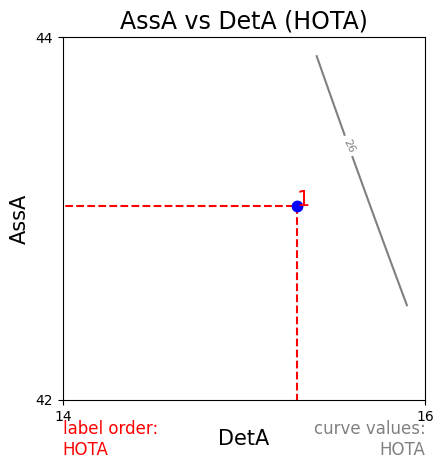

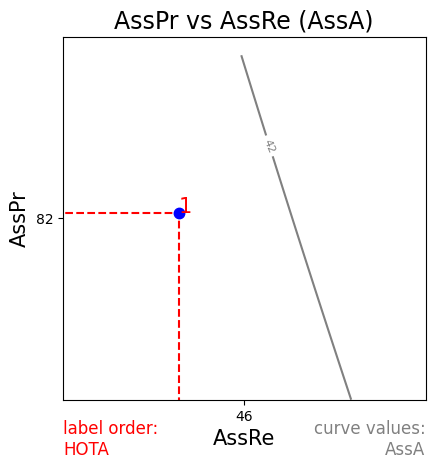

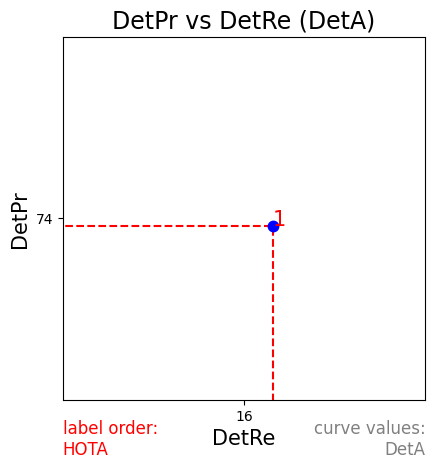

In [30]:
if 'tracker' not in globals():
    tracker = MOTTracker(CONFIG)
    
if CONFIG['validation']['enabled']:
    val_sequence = CONFIG['validation']['val_sequence']
    print("Setting up BYTETrack results directory for evaluation...")
    hota_results = tracker.evaluate_with_hota(val_sequence)

# Process test sequence
test_sequence = CONFIG['data']['test_seq']
print(f"Processing test sequence: {test_sequence}")
test_results = tracker.process_sequence(test_sequence)
    
# Generate submission
submission = tracker.generate_submission()
    
# End timer
end_time = time.time()
print(f"Total processing time: {end_time - start_time:.2f} seconds")

In [35]:
!mkdir -p results
!cp /kaggle/working/results/01/visualization/frame_000013.jpg results/frame_000013_seq1.jpg
!cp /kaggle/working/results/02/visualization/frame_002239.jpg results/frame_002239_seq2.jpg
!cp /kaggle/working/test_results/predict/000010.jpg results/000010_test_predict.jpg


### Sequence 1
![Tracking result on Sequence 1](results/frame_000013_seq1.jpg)

### Sequence 2
![Tracking result on Sequence 2](results/frame_002239_seq2.jpg)

### Test Prediction Example
![Sample test prediction](results/000010_test_predict.jpg)


### Video Demonstrations
- [Tracking at 30 FPS](https://drive.google.com/file/d/1AEi_QZJP4BCUQNTsNGE4GfsvIeHxXh6g/view?usp=drive_link)
- [Tracking at 60 FPS](https://drive.google.com/file/d/1jRoDEGrPzyqAm-li5Kb4R_ceY890QDCC/view?usp=drive_link)
